In [ ]:
%%capture
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install langdetect
!pip install contractions
!pip install beautifulsoup4

In [ ]:
import re
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

import gensim
import nltk
import pandas as pd
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from wordcloud import WordCloud
import contractions
from bs4 import BeautifulSoup
from textblob import TextBlob

# Download required nltk data
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
df = pd.read_csv("/kaggle/input/suicide-watch/Suicide_Detection.csv")

df.drop(df[(df['text'] =='\\[removed\\]')].index, inplace=True)
df.drop(df[(df['text'] =='[removed]')].index, inplace=True)

df.drop(df[(df['class'] =='\\[removed\\]')].index, inplace=True)
df.drop(df[(df['class'] =='[removed]')].index, inplace=True)

df.dropna(inplace=True)
df = df[['text', 'class']]

df.sample(2)

In [2]:
import re
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

import gensim
import nltk
import pandas as pd
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from wordcloud import WordCloud
import contractions
from bs4 import BeautifulSoup
from textblob import TextBlob

# Download required nltk data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def remove_stopwords(text):
    new_list = []
    words = nltk.word_tokenize(text)
    stopwrds = set(stopwords.words('english')) - {'not'}
    stopwrds.update(['d', 'm', 's', 're', 've', 'll'])

    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

abbr_dict = {
    "ain t": "am not",
    "can t": "can not",
    "cannot": "can not",
    "couldn t": "could not",
    "didn t": "did not",
    "gotta": "got to",
    "hadn t": "had not",
    "hasn t": "has not",
    "haven t": "have not",
    "imma": "i am going to",
    "isn t": "is not",
    "shouldn t": "should not",
    "smthg": "some thing",
    "wasn t": "was not",
    "weren t": "were not",
    "won t": "will not",
    "wouldn t": "would not",
    "wouldn t ve": "would not have",
}

def misspelled_abbreviations(text):
    text = re.sub('’', '\'', text)

    for abbr, expanded_form in abbr_dict.items():
        text = text.replace(abbr, expanded_form)
        
    return text

In [6]:
%%time

from multiprocessing import Pool, cpu_count

def preprocess_wrapper(args):
    index, line = args
    return index, preprocess_text(line)

def parallel_preprocess(df):
    num_processes = cpu_count()
    pool = Pool(processes=num_processes)
    result = pool.map(preprocess_wrapper, df['text'].items())
    pool.close()
    pool.join()
    
    for index, preprocessed_text in tqdm(result, total=len(result)):
        df.at[index, 'text'] = preprocessed_text

parallel_preprocess(df)

100%|██████████| 232074/232074 [00:05<00:00, 39403.02it/s]

CPU times: user 7.16 s, sys: 884 ms, total: 8.04 s
Wall time: 3min 11s


In [7]:
df.sample(5)

,text,class
100137,second night week take morphine calm downits n...,suicide
196736,hey reddit please comment notices bulgy wulgy ...,non-suicide
8506,boobie person butt person personally boobie pe...,non-suicide
75039,caught shiny pokemon never probably filler hhh...,non-suicide
29771,audacity assume people recognize none special,non-suicide


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import joblib

In [9]:
X = df['text']
y = df['class']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(label_encoder.classes_)

['non-suicide' 'suicide']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_encoded, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [11]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', verbose=True))
])

In [12]:
SVM = pipeline.fit(X_train, y_train)

[LibSVM]....................................................................*.....................................*....*
optimization finished, #iter = 108915
obj = -26976.574712, rho = -1.018614
nSV = 40701, nBSV = 27520
Total nSV = 40701


In [15]:
joblib.dump(SVM, 'SVM.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [31]:
import numpy as np
sentences = [
    "It's a dark, suffocating weight, the constant companion of someone who suffers from suicidal thoughts.",
    "It's a constant battle against the darkness within, a relentless struggle for someone plagued by thoughts of suicide.",
    "Today is a beautiful day!",
    "I'm so grateful for the little things."
]
sentences = list(map(lambda sentence: preprocess_text(sentence), sentences))

pred_labels = SVM.predict(sentences)
pred_class = [label_encoder.classes_[label] for label in pred_labels]
for sentence, pred_class in zip(sentences, pred_class):
    print("Sentence:", sentence)
    print("Predicted Class:", pred_class)
    print()

Sentence: dark suffocating weight constant companion someone suffers suicidal thoughts
Predicted Class: suicide

Sentence: constant battle darkness within relentless struggle someone plagued thoughts suicide
Predicted Class: suicide

Sentence: today beautiful day
Predicted Class: non-suicide

Sentence: grateful little things
Predicted Class: non-suicide



In [20]:
y_pred = SVM.predict(X_test)

y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

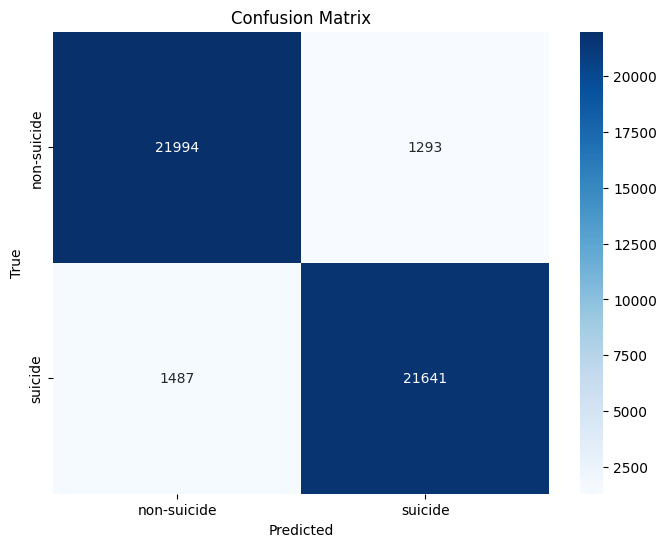

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test_original, y_pred_original)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()